In [257]:
import pm4py
import pandas as pd
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.conformance.footprints import algorithm as footprints_algo
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
from pm4py.algo.conformance.tokenreplay import algorithm as tokenreplay_algo

from pm4py.visualization import footprints as vis_footprints
import graphviz

from IPython.display import HTML, display
from statsmodels.tsa.vector_ar.util import comp_matrix


# Preparing Data

## Data from Assignment 1

Given the following Log (from assignment 1), a process model was discovered using the Alpha Miner algorithm. The provided logs were copied to a CSV file for easier use. The log contains the following columns:
- CaseID: Unique identifier for each case.
- Activity: Name of the activity performed.

No timestamps are provided in this log. For usage with PM4Py, a dummy timestamp column will be added and populated with consecutive values.

In [258]:
og_logs_path = "og_logs.csv"
og_log_df = pd.read_csv(og_logs_path)
og_log_df

,CaseID,Activity
0,1,a
1,1,c
2,1,f
3,1,b
4,2,a
5,2,e
6,2,g
7,2,c
8,2,f
9,2,d


In [259]:
# add timestamp column with consecutive dummy values
og_log_df["Timestamp"] = pd.date_range(start="2023-01-01", periods=len(og_log_df), freq="min")

In [260]:
og_event_log = pm4py.format_dataframe(og_log_df, case_id="CaseID", activity_key="Activity", timestamp_key="Timestamp")
og_event_log = pm4py.convert_to_event_log(og_event_log)

## New Logs

Additional logs are provided in the assignment. These logs were also copied to CSV files for easier use. The logs contain the same columns as the original log.

In [261]:
new_logs_path = "new_log.csv"
new_log_df = pd.read_csv(new_logs_path)
new_log_df

,CaseID,Activity
0,4,a
1,4,d
2,4,e
3,4,g
4,5,a
5,5,c
6,5,f
7,5,d
8,5,b
9,6,f


In [262]:
# add timestamp column with consecutive dummy values
new_log_df["Timestamp"] = pd.date_range(start="2023-01-01", periods=len(new_log_df), freq="min")

In [263]:
new_event_log = pm4py.format_dataframe(new_log_df, case_id="CaseID", activity_key="Activity", timestamp_key="Timestamp")
new_event_log = pm4py.convert_to_event_log(new_event_log)

# Analysis

## Causal Footprint

In order to perform the causal footprint analysis, we will first compute the footprints for both the original and new logs. The footprints will then be compared to identify any differences in the causal relationships between activities.

In [264]:
og_footprints = footprints_discovery.apply(og_event_log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
new_footprints = footprints_discovery.apply(new_event_log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

In [267]:
cf_result = footprints_algo.apply(new_footprints, og_footprints)
cf_result

{('a', 'c'),
 ('a', 'd'),
 ('a', 'e'),
 ('c', 'e'),
 ('c', 'f'),
 ('d', 'b'),
 ('d', 'c'),
 ('d', 'e'),
 ('e', 'f'),
 ('e', 'g'),
 ('f', 'b'),
 ('f', 'd'),
 ('g', 'd')}

To calculate the conformance score based on the causal footprint differences, we can count the number of differing relations and divide it by the total possible relations. The conformance score is then calculated as 1 minus this ratio.

In [268]:
cf_conformance = 1 - (len(cf_result) / len(og_footprints['activities']) ** 2)
cf_conformance

0.7346938775510203

Given the original model, the new logs have a causal footprint conformance score of approximately 0.73, indicating that there are some differences in the causal relationships between activities in the new logs compared to the original model.

### Interpretation of Results

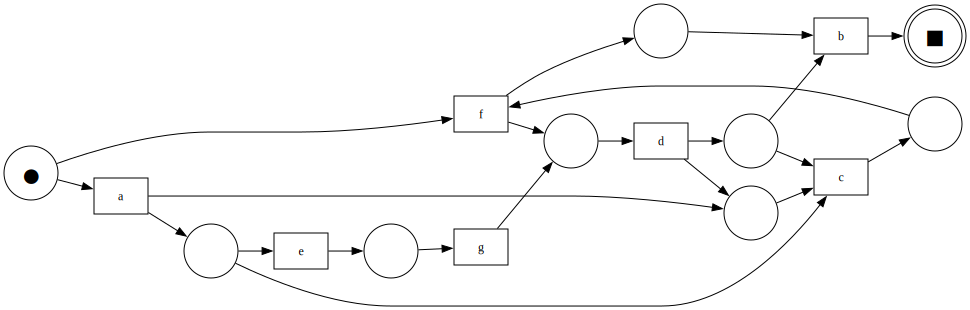

In [269]:
og_net, og_im, og_fm = alpha_miner.apply(og_event_log)
pm4py.visualization.petri_net.visualizer.apply(og_net, og_im, og_fm)

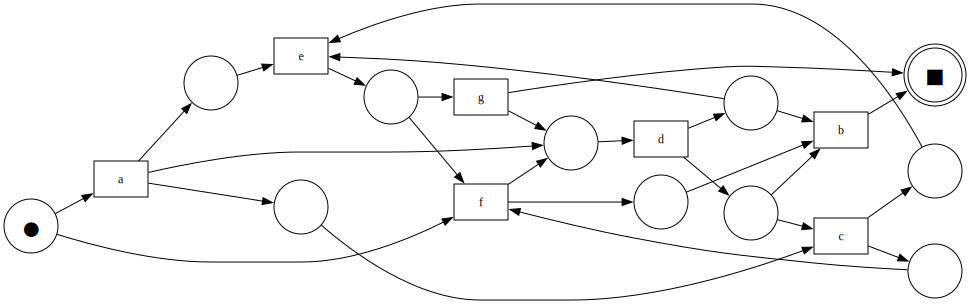

In [270]:
new_net, new_im, new_fm = alpha_miner.apply(new_event_log)
pm4py.visualization.petri_net.visualizer.apply(new_net, new_im, new_fm)

By visually comparing the two process models, we can see that there are differences in the structure of the models. Without going into too much detail, the model derived from the new logs appears to have additional paths that are not present in the original model.

In [271]:
def add_title_to_graphviz_source(source, title):
    source_code = source.source

    insertion_point = source_code.find('{') + 1
    new_source_code = (
        source_code[:insertion_point] +
        f'\n    label="{title}";\n    labelloc="t";\n    fontsize="20";\n' +
        source_code[insertion_point:]
    )

    source_titled = graphviz.Source(new_source_code)

    return source_titled

In [280]:
og_matrix = vis_footprints.visualizer.apply(og_footprints, variant=pm4py.visualization.footprints.visualizer.Variants.SINGLE)
og_matrix_titled = add_title_to_graphviz_source(og_matrix, "Footprint Matrix of Model")

In [277]:
new_matrix = vis_footprints.visualizer.apply(new_footprints, variant=pm4py.visualization.footprints.visualizer.Variants.SINGLE)
new_matrix_titled = add_title_to_graphviz_source(new_matrix, "Footprint Matrix of New Logs")

In [305]:
comp_matrix = vis_footprints.visualizer.apply(new_footprints, og_footprints, variant=pm4py.visualization.footprints.visualizer.Variants.COMPARISON)
comp_matrix_titled = add_title_to_graphviz_source(comp_matrix, "Comparison of Footprint Matrices")

In [306]:
svg1 = og_matrix_titled.pipe(format='svg').decode('utf-8')
svg2 = new_matrix_titled.pipe(format='svg').decode('utf-8')
svg3 = comp_matrix_titled.pipe(format='svg').decode('utf-8')
html_code = f"""
<div style="display: flex; justify-content: center; align-items: flex-start;">
    <div style="margin: 10px;">{svg1}</div>
    <div style="margin: 10px;">{svg2}</div>
    <div style="margin: 10px;">{svg3}</div>
</div>
"""

display(HTML(html_code))

Comparing the two footprint matrices, we can observe some difference. For instance, the parallel relation (||) between activities c and g are not present in the footprint of the new logs.

## Token-based Replay

In [297]:
tbr_result = tokenreplay_algo.apply(new_event_log, og_net, og_im, og_fm)

replaying log with TBR, completed traces :: 100%|██████████| 5/5 [00:00<00:00, 1684.59it/s]


In [298]:
pm4py.conformance.fitness_token_based_replay(new_event_log, og_net, og_im, og_fm)

replaying log with TBR, completed traces :: 100%|██████████| 5/5 [00:00<00:00, 2328.10it/s]


{'perc_fit_traces': 0.0,
 'average_trace_fitness': 0.0,
 'log_fitness': 0.0,
 'percentage_of_fitting_traces': 0.0}

In [299]:
tbr_result

[{'trace_is_fit': False,
  'trace_fitness': 0.0,
  'activated_transitions': [],
  'reached_marking': ['start:1'],
  'enabled_transitions_in_marking': {( a, ' a')},
  'transitions_with_problems': [],
  'missing_tokens': 1,
  'consumed_tokens': 1,
  'remaining_tokens': 1,
  'produced_tokens': 1},
 {'trace_is_fit': False,
  'trace_fitness': 0.0,
  'activated_transitions': [],
  'reached_marking': ['start:1'],
  'enabled_transitions_in_marking': {( a, ' a')},
  'transitions_with_problems': [],
  'missing_tokens': 1,
  'consumed_tokens': 1,
  'remaining_tokens': 1,
  'produced_tokens': 1},
 {'trace_is_fit': False,
  'trace_fitness': 0.0,
  'activated_transitions': [],
  'reached_marking': ['start:1'],
  'enabled_transitions_in_marking': {( a, ' a')},
  'transitions_with_problems': [],
  'missing_tokens': 1,
  'consumed_tokens': 1,
  'remaining_tokens': 1,
  'produced_tokens': 1},
 {'trace_is_fit': False,
  'trace_fitness': 0.0,
  'activated_transitions': [],
  'reached_marking': ['start:1']

In [302]:
new_event_log.index(0)

TypeError: slice indices must be integers or have an __index__ method